## Imports 

In [1]:
%pip install GPUtil
%pip install torchsummary

  Preparing metadata (setup.py) ... - \ done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=04adec0d5702951c413f3c835fba8e6576008465f4e49b9655502413ea16e434
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
import numpy as np
import pandas as pd
import random
import math
import pickle
import os
import pathlib
from tqdm import tqdm

## for visualisation
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

## for ML 
from skimage.measure import label, regionprops, regionprops_table
import sklearn.metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## for DL
from GPUtil import showUtilization as gpu_usage
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
import time
import torch
import torchvision
import torch.optim as optim
import albumentations as A
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import ConvTranspose2d
from torch.nn import Conv2d
from torch.nn import MaxPool2d
from torch.nn import Module
from torch.nn import ModuleList
from torch.nn import ReLU
from torch.nn import Dropout
# from torchsummary import summary
from torchinfo import summary

from torch.nn import BatchNorm2d 

from torchvision.transforms import CenterCrop
from torch.nn import functional as F
from torch.nn.functional import normalize

In [3]:
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
# print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
# print('Active CUDA Device: GPU', torch.cuda.current_device())
print ('Available devices ', torch.cuda.device_count())

print(gpu_usage())

__Python VERSION: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
__pyTorch VERSION: 2.1.2
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
__CUDNN VERSION: 8900
__Number CUDA Devices: 2
Available devices  2
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
None


## Dataset creatioin 
### Extraction --> filtering --> property  --> class creation 
- medical image cn https://learnopencv.com/medical-multi-label/
- response map on image https://learnopencv.com/fully-convolutional-image-classification-on-arbitrary-sized-image/
- https://glassboxmedicine.com/2022/01/21/building-custom-image-data-sets-in-pytorch-tutorial-with-code/
- https://stackoverflow.com/questions/62434037/python-class-dataset-how-to-concatenate-images-with-their-respective-labels-in
- imbalance in dataset https://neptune.ai/blog/how-to-deal-with-imbalanced-classification-and-regression-data


#### creatiing resnet
- https://www.kaggle.com/code/poonaml/building-resnet34-from-scratch-using-pytorch

In [4]:
def plotSanityCheckImages(imgList, name):
    """create a functin to check the cropped images"""
    figure, axs = plt.subplots(nrows=3, ncols=5, figsize=(10,5), sharex = False, sharey = False)
    # print(len(imgList))
    for i, ax in enumerate(axs.flatten()):
        index = random.randrange(len(imgList))
        image = imgList[index]
        ax.imshow(image)
        ax.grid(False)
        
    figure.suptitle(f"Total '{len(imgList)}' unique images in {name} SET", fontsize = 10)
    plt.tight_layout()
    plt.show()
    return None



def classDistributionCheck(propList, dataPath, filterCols, featureCols, _dir,  setName):
    figure, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,6))
    colors = ['#FF6B6B', '#1F77B4', '#FF6B6B', '#009988', '#EE7733', '#CC3311', '#9ECAE1', '#33BBEE', '#EE7733',
             '#45B7D1', '#FFA07A', '#6BAED6', '#45B7D1',
              '#FF6B6B', '#1F77B4', '#009988', '#4ECDC4', '#4ECDC4']
  
    for idx, (ax, prop) in enumerate(zip(axs.flatten(), propList)):
        dataSet = ebDataset(dataPath, combinedCsvPath, filterCols, featureCols, 
                            prop=prop, transform=False, num_augmentations=0)
        data = dataSet.spheroidInfo[2]
        series = pd.Series(data)
        value_counts = series.value_counts()
        
        # Create bar plot
        value_counts.plot(kind='bar', ax=ax, color = [colors[3*(idx)], colors[(idx+1)]])
        
        # Add title and labels
        ax.set_title(f'{prop} Distribution')
        ax.set_ylabel('Count')
        
        # Add count labels on top of each bar
        for i, v in enumerate(value_counts):
            ax.text(i, v, str(v), ha='center', va='bottom')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        

    plt.tight_layout()
    plt.suptitle(f'Class Distribution for {setName} set with {len(dataSet)} data points', fontsize=16)
    plt.subplots_adjust(top=0.9)
    

    save_path = os.path.join(_dir, f'{setName}_class_distribution.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
        
    

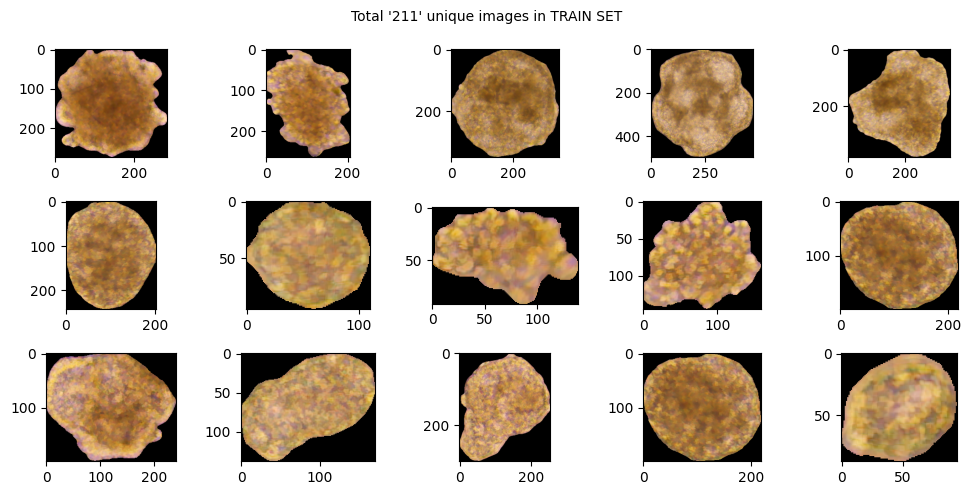

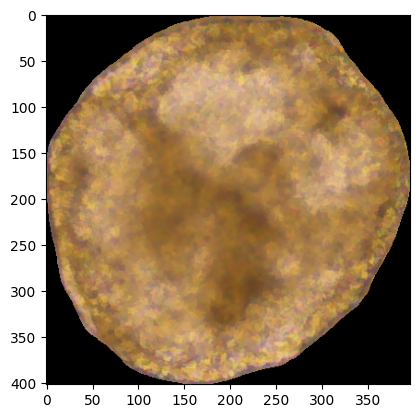

NonCystic 0


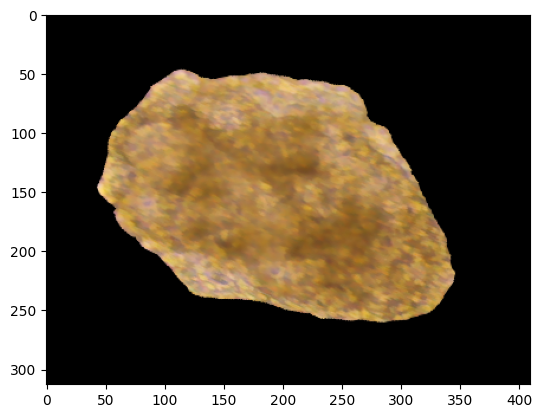

In [5]:
class ebDataset(Dataset):
    def __init__ (self, imagePath, combinedCsvPath, filterCols, featureCols, 
                  dev = False, prop = None, transform = None, num_augmentations = 0):
        self.imagePath = imagePath
        self.combinedCsvPath = combinedCsvPath
        self.filterCols = filterCols
        self.featureCols = featureCols
        self.prop = prop
        self.dev = dev
        self.transform = transform
        self.num_augmentations = num_augmentations

        # get the spheroid images
        self.spheroidInfo = self.readData(self.imagePath)
        
    
    def yPropCreate(self, feature_dic, _prop):
        """ Adds a target to the csv based on the input provided for a particular metric development """
        _prop = _prop.lower()

        if _prop == 'density':
            prop = ['LightEB', 'DenseEB']
            prop = 'LightEB' if (prop == ['LightEB']) else 'DenseEB'
            _label = 1 if (prop == 'LightEB') else 0

        elif _prop == 'outline':
            prop = ['SmoothOutline', 'RoughOutline', 'VeryRoughOutline']
            prop = list(set(feature_dic) & set(prop))
            prop = 'RoughOutline' if (prop == ['RoughOutline'] or prop == ['VeryRoughOutline']) else 'SmoothOutline'
            _label = 1 if (prop == 'RoughOutline') else 0

        elif _prop == 'cysticity':
            prop = ['NonCytstic', 'Cytstic', 'HeavilyCystic']
            prop = list(set(feature_dic) & set(prop))
            prop = 'Cystic' if (prop == ['HeavilyCystic'] or prop == ['Cytstic']) else 'NonCystic'
            _label = 1 if (prop == 'Cystic') else 0

        elif _prop == 'shape':
            prop = ['IrregularShaped', 'RoundShaped', 'OvalShaped']
            prop = list( set(feature_dic) & set(prop))
            prop = 'RoundShaped' if (prop == ['OvalShaped'] or prop == ['RoundShaped']) else 'IrregularShaped'
            _label = 1 if (prop == 'RoundShaped') else 0
            
        else: return print("wrong input, add either 'density','outline','cysticity', 'shape'")
        return _prop, prop, _label
    
    def filterSpheroids(self, spheroidInfoDic, combinedCsvPath, filterCols, featureCols ):
        _images, _masks, _property, _label = [], [], [], []
        comb_df = pd.read_csv(combinedCsvPath)
        
        for index, spheroidName in enumerate(spheroidInfoDic):
            cropped_segMask, cropped_segImage = spheroidInfoDic[spheroidName][2], spheroidInfoDic[spheroidName][4]      
            x = comb_df[comb_df['example'] == spheroidName]
            filterTags = list(x[filterCols].values.flat)
            featureTags = list(x[featureCols].values.flat)

            if ('Edge' in filterTags) or ('CannotDetermine' in filterTags):
                continue
            elif ('Center' in filterTags) and ('CanDetermine' in filterTags) : 
                        # print(f'\nselected---{filterTags}---{spheroidName}')
                _images.append(cropped_segImage)
                mask = np.where(np.array(cropped_segMask) >= 1, 1.0, 0.0)
                _masks.append(mask)
                        # add fature tags
                propName, prop, label = self.yPropCreate(featureTags, self.prop)
                _property.append(prop)
                _label.append(label)
        return (_images, _masks, _property, _label)
    
    def readData(self, imagePath):        
        """Reads and creates a list of EB with corresponding feature tags"""
        _images, _masks, _property, _label = [], [], [], []
        for dirname, _, filenames in os.walk(imagePath):
            ## get the spheroid images
            for filename in filenames:
                if (filename == '.DS_Store' or 
                    pathlib.Path(filename).suffix == '.pickle' or 
                    pathlib.Path(filename).suffix == '.csv'):
                    continue
                else:
                    path = os.path.join(dirname, filename)
                    with open(path, 'rb') as f:
                        data = pickle.load(f)
                    # mask, oriImage, spheroidInfoDic, markedImage = data[0], data[1], data[2], data[3]
                    spheroidInfoData = self.filterSpheroids(data[2], self.combinedCsvPath, self.filterCols, self.featureCols)
                    _images.extend(spheroidInfoData[0]); _masks.extend(spheroidInfoData[1]);
                    _property.extend(spheroidInfoData[2]), _label.extend(spheroidInfoData[3])
        return (_images, _masks, _property, _label)
    
    
    def __len__(self):
        if self.num_augmentations > 1:
            length = len(self.spheroidInfo[0]) * self.num_augmentations
        else:
            length = len(self.spheroidInfo[0])
        return len(self.spheroidInfo[0]) #length
    
    def dataTransform(self, image, mask):
        transform = A.Compose([A.HorizontalFlip(p = 0.51),
                               A.VerticalFlip(p = 0.51),
                               A.SafeRotate(p = 0.51, border_mode = 0),
                              ])
        augmentations = transform(image = np.array(image), mask = np.array(mask))
        return augmentations["image"], augmentations["mask"]
    
    
    def imperativeDataTransform(self, image, mask):
        transform = A.Compose([A.SafeRotate(p = 1, border_mode=0) #interpolation=2,  # int
                              ])
        augmentations = transform(image = np.array(image), mask = np.array(mask))
        return augmentations["image"], augmentations["mask"]
    
    def __getitem__(self, idx):
        # read data coming from getitem function
        _ebImages , _mask , _property , _label = self.spheroidInfo
        
        # mandatory transformation on minority class
        if self.num_augmentations > 1:
            idx = idx // self.num_augmentations
            _img, _mask, _prop, _propLabel = _ebImages[idx], _mask[idx], _property[idx], _label[idx]
            if (idx % self.num_augmentations) != 0 and _label == 1:
                _img, _mask = self.imperativeDataTransform(_img, _mask)
#                 plt.imshow(_img)
#                 plt.show()
        else:
            _img, _mask, _prop, _propLabel = _ebImages[idx], _mask[idx], _property[idx], _label[idx]
#             plt.imshow(_img)
#             plt.show()

        if self.transform == True:
            _img, _mask  = self.dataTransform(_img, _mask)
                
        return _img, _mask, _prop, _propLabel
    

testSet_imgPath = '/kaggle/input/profiling-of-spheroids/testSpheroidDetails'
combinedCsvPath = "/kaggle/input/profiling-of-spheroids/combined_csvPath/combinedAnnotated.csv"
filterCols = ['Location_tags', 'Determine_tags']
featureCols = ['Overlapping_tags', 'Connected_tags','Density_tags', 
               'Outline_tags','Cystic_tags', 'Shape_tags']
prop = 'cysticity'
# images, masks, property, label 
item = ebDataset(testSet_imgPath, combinedCsvPath, filterCols, featureCols, 
                 prop = prop,  num_augmentations = 2, transform = True)
plotSanityCheckImages(item.spheroidInfo[0], 'TRAIN')
plt.imshow(item[0][0])
plt.show()
plt.imshow(item[15][0])
print(item[15][2], item[15][3])

# next(item)



## checking the classes

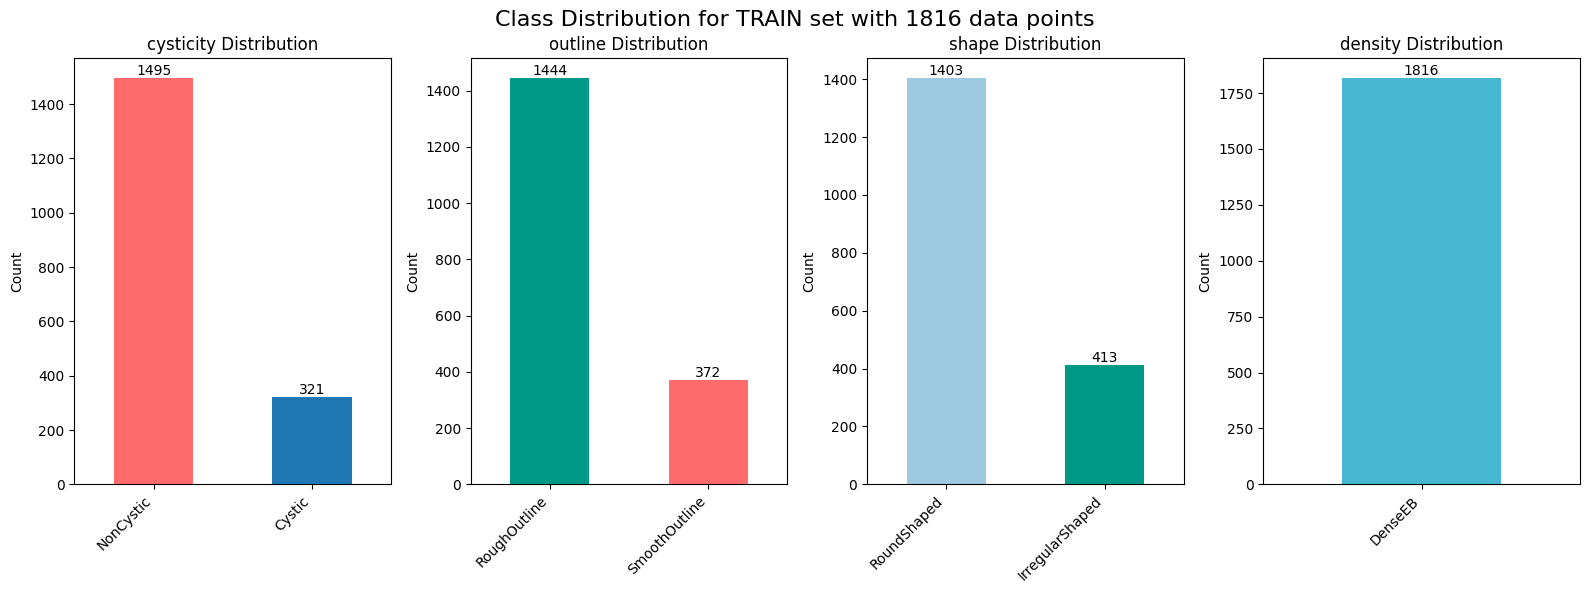

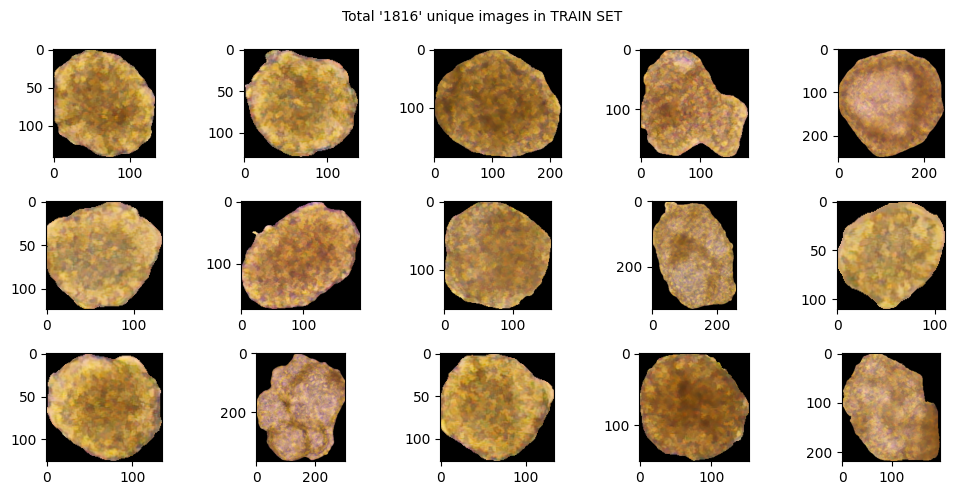

In [6]:
trainSet_imgPath = '/kaggle/input/profiling-of-spheroids/spheroidDetails' 

combinedCsvPath = '/kaggle/input/profiling-of-spheroids/combined_csvPath/combinedAnnotated.csv'
filterCols = ['Location_tags', 'Determine_tags']
featureCols = ['Overlapping_tags', 'Connected_tags','Density_tags', 'Outline_tags','Cystic_tags', 'Shape_tags']
prop = 'cysticity' #'outline' #'density','outline','cysticity', 'shape'

TrainDataset = ebDataset(trainSet_imgPath, combinedCsvPath, filterCols, featureCols,
                         prop = prop, transform = False, num_augmentations = 0)
propList = ['cysticity','outline','shape', 'density']
BASE_OUTPUT = "/kaggle/working"
                         
classDistributionCheck(propList, trainSet_imgPath, filterCols, featureCols, BASE_OUTPUT, 'TRAIN'  )
plotSanityCheckImages(TrainDataset.spheroidInfo[0], 'TRAIN')

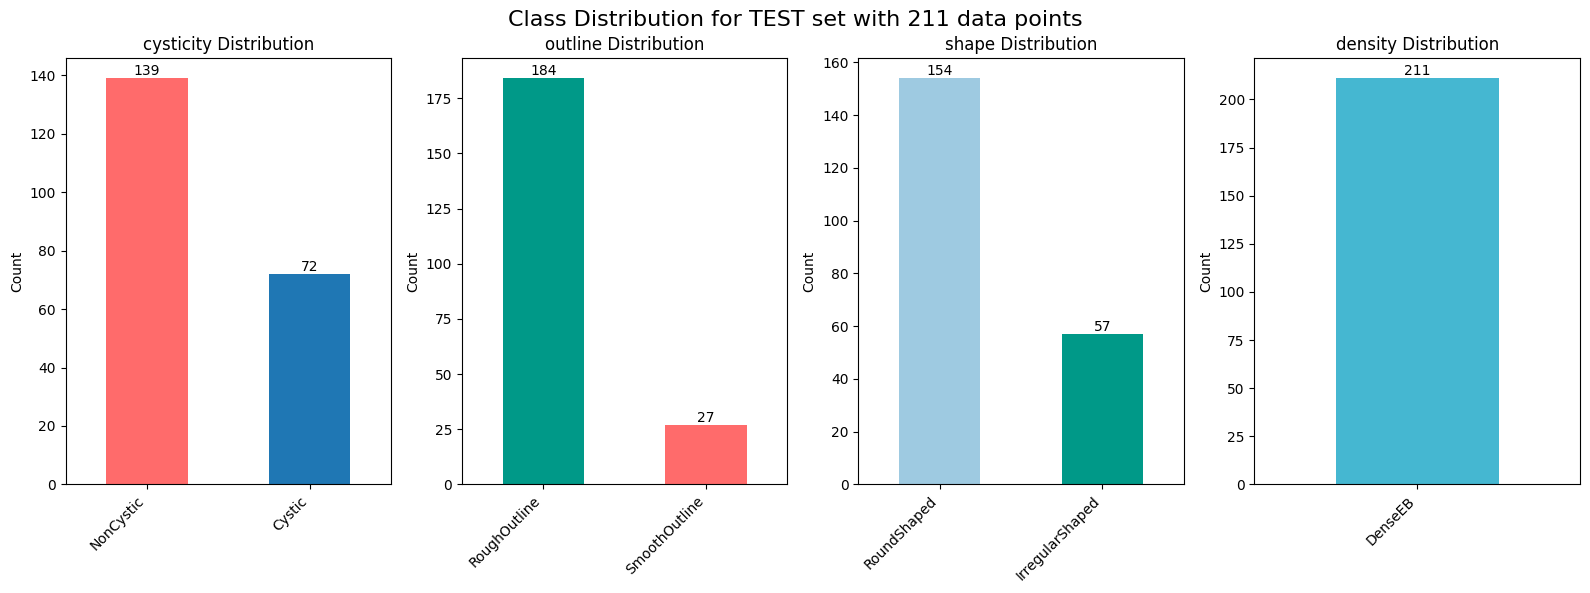

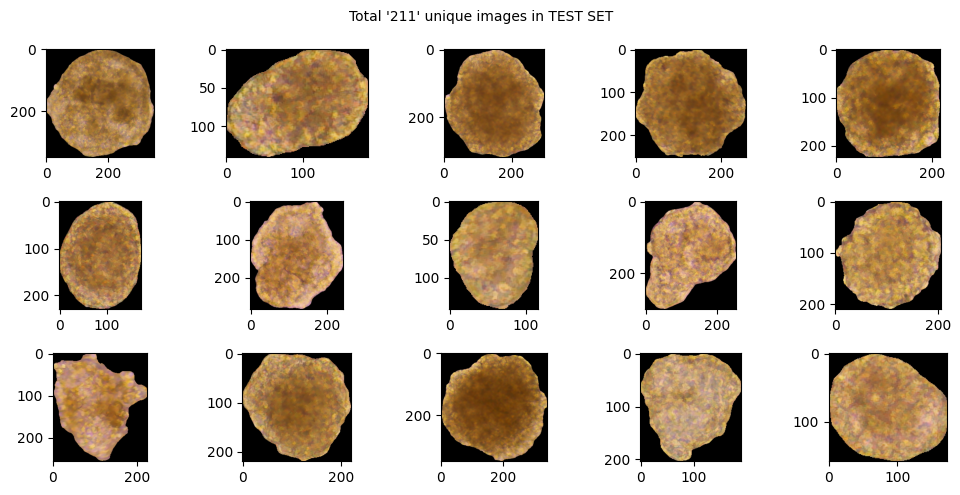

In [7]:
testSet_imgPath = '/kaggle/input/profiling-of-spheroids/testSpheroidDetails'
combinedCsvPath = '/kaggle/input/profiling-of-spheroids/combined_csvPath/combinedAnnotated.csv'
filterCols = ['Location_tags', 'Determine_tags']
featureCols = ['Overlapping_tags', 'Connected_tags','Density_tags', 'Outline_tags','Cystic_tags', 'Shape_tags']
prop = 'cysticity' #'outline' #'density','outline','cysticity', 'shape'

TestDataset = ebDataset(testSet_imgPath, combinedCsvPath, filterCols, featureCols, 
                        prop = prop, transform = None, num_augmentations = 2)
propList = ['cysticity','outline','shape', 'density']
BASE_OUTPUT = "/kaggle/working"

classDistributionCheck(propList, testSet_imgPath, filterCols, featureCols, BASE_OUTPUT, 'TEST'  )
plotSanityCheckImages(TestDataset.spheroidInfo[0], 'TEST')


## dataLoader creation 

- collate func for paddig https://stackoverflow.com/questions/55041080/how-does-pytorch-dataloader-handle-variable-size-data 
    -- https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/15 -- https://plainenglish.io/blog/understanding-collate-fn-in-pytorch-f9d1742647d3 -- https://stackoverflow.com/questions/55041080/how-does-pytorch-dataloader-handle-variable-size-data
- padding to the same dimenions https://stackoverflow.com/questions/61943896/pad-torch-tensors-of-different-sizes-to-be-equal 
- torch stacking https://discuss.pytorch.org/t/dataloader-for-various-length-of-data/6418/8

In [8]:
def max_HeightWidth(batch):
    # _height , _width = [], []
    # for item in batch:
    #     _height.append(item[0].shape[0])
    _height = max((item[0].shape[0]) for item in batch)
    _width = max((item[0].shape[1]) for item in batch)

    return _height, _width #max(_height), max(_width)

def img_padding(batch, max_height, max_width):
    _image_batch, _mask_batch = [], []
    for item in batch:
        img, mask, tag, label = item
        # print(img.shape, mask.shape)
        img_padding = (0, 0, 0, max_width - img.shape[1], 0 ,max_height - img.shape[0])
        mask_padding = (0, max_width - mask.shape[1], 0 ,max_height - mask.shape[0])
        padded_img = F.pad(torch.from_numpy(img), img_padding).permute(2,0,1) # shuffing the dim order to [HWC -> CHW]
        padded_mask = F.pad(torch.from_numpy(mask), mask_padding)
        
        _image_batch.append(padded_img)
        # _image_batch.append(padded_img[0])
        _mask_batch.append(padded_mask)

    return _image_batch, _mask_batch

def custom_collate(batch, _RGB = None):
    import torch.nn.functional as F

    max_height, max_width = max_HeightWidth(batch)
    image_batch, mask_batch = img_padding(batch, max_height, max_width)

    images = torch.stack([item for item in image_batch], dim = 0)
    mask = torch.stack([item for item in mask_batch])  # each element is of size (1, h*, w*). where (h*, w*) changes from mask to another.
    tags = [item[2] for item in batch]
    label = torch.LongTensor([item[3] for item in batch])

    return images, mask, tags, label


def cDataLoaderCheck(dataLoader, _prop, batch, setName, _dir):
    num_plots = len(dataLoader)
    rows = batch
    cols = math.ceil(num_plots / batch)
    
    fig, axes = plt.subplots(nrows = rows, ncols = rows, figsize=(20, batch*2), sharex = False, sharey = True)
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier indexing
    
    colors = ['#1F77B4', '#FF6B6B']
    
    for idx, (ax, item) in enumerate(zip(axes.flatten(), dataLoader)):
        if idx >= len(axes):
            break  # Stop if we've used all available subplots
        
#         item = dataLoader[index]
        value_counts = pd.Series(item[2]).value_counts()
        
        # Create bar plot
        value_counts.plot(kind='bar', ax=axes[idx], color=colors)
        
        for i, v in enumerate(value_counts):
            axes[idx].text(i, v, str(v), ha='center', va='bottom')
        
        # Add title and labels
        axes[idx].set_title(f'B-{idx+1}')
        axes[idx].set_ylabel('Count')
        axes[idx].tick_params(axis='x', rotation=35)
    
    # Remove any unused subplots
    for idx in range(num_plots, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.suptitle(f'Class Distribution random {batch * batch} spheroids for {_prop} of \n {setName} set', fontsize=16)
    plt.subplots_adjust(top = 0.93)
    
    save_path = os.path.join(_dir, f'{setName}_Batch_distribution.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    

def checkDataLoader(_dataloader):
    count = 0
    for idx, item in enumerate(_dataloader):
        cls = pd.Series(item[2]).value_counts()
        if len(cls) != 2:
            count += 1
            # print(f'{idx+1} - Batch \n{pd.Series(item[2]).value_counts()}\n')
            continue
        diff = abs(cls.iloc[0] - cls.iloc[1])
        if diff >3: 
            count += 1
            # print(f'{idx+1} - Batch \n{pd.Series(item[2]).value_counts()}\n')
            
    print(f'{count} imbalance batches (>3) in total {len(_dataloader)} batches')

    
# https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
from torchvision.utils import make_grid

def show_batch(data_loader, batch, _showMore = None):
    """Plot images grid of single batch"""
    for i, item in enumerate(data_loader):
        images = item[0]
        mask = item[1]
        tags = item[2]
        label = item[3]
        fig,ax = plt.subplots(figsize = (20, 10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = batch).permute(1,2,0)) # b is from batch size above cell
        # plt.title([tags, label])
        _title = f'{[tags]} \n {[label]}' 
        plt.title(_title)
        plt.tight_layout
        if (i == 5) and (_showMore == False) :
            break


            

In [9]:
# checking dataloader usinf test set
validation_split = 0.3
b = 30
BASE_OUTPUT = "/kaggle/working"
prop = 'cysticity' #'outline' #'density','outline','cysticity', 'shape'
# RGB = True
testSet_imgPath = '/kaggle/input/profiling-of-spheroids/testSpheroidDetails'
combinedCsvPath = '/kaggle/input/profiling-of-spheroids/combined_csvPath/combinedAnnotated.csv'
testDataset = ebDataset(testSet_imgPath, combinedCsvPath, filterCols, featureCols,
                         prop = prop, transform = False, num_augmentations = 0)

train_set, validation_set = torch.utils.data.random_split(TrainDataset, [round(len(TrainDataset)*(1-validation_split)),
                                                                         round(len(TrainDataset)*validation_split)])                                       
Loader = DataLoader(dataset = train_set, batch_size = b, 
                         collate_fn = custom_collate, num_workers = 0, shuffle = True)

# cDataLoaderCheck(Loader, _prop = prop, batch=10, setName='TestSet without any Sampler', _dir = BASE_OUTPUT)
checkDataLoader(Loader)

42 imbalance batches (>3) in total 43 batches


In [10]:
validation_split = 0.3
b = 30
BASE_OUTPUT = "/kaggle/working"
prop = 'cysticity' #'outline' #'density','outline','cysticity', 'shape'
# RGB = True
trainSet_imgPath = '/kaggle/input/profiling-of-spheroids/spheroidDetails' 
TrainDataset = ebDataset(trainSet_imgPath, combinedCsvPath, filterCols, featureCols,
                         prop = prop, transform = False, num_augmentations = 0)


train_set, validation_set = torch.utils.data.random_split(TrainDataset, [round(len(TrainDataset)*(1-validation_split)),
                                                                         round(len(TrainDataset)*validation_split)])  

# Access spheroidInfo from the original dataset
train_data = [TrainDataset.spheroidInfo[2][i] for i in train_set.indices]
data = pd.Series(train_data)
# data = pd.Series(train_set.dataset.spheroidInfo[2])

# Calculate class weights
class_counts = data.value_counts()
class_weights = 1. / torch.tensor(class_counts.values, dtype=torch.float32)

sample_weights = [1/class_counts[i] for i in data.values]; 

wSampler= WeightedRandomSampler(weights = sample_weights, num_samples = len(train_set), replacement=True)
trainLoader = DataLoader(dataset = train_set, batch_size = b, sampler = wSampler,
                         collate_fn = custom_collate, num_workers = 0)

print(f"Dataset length: {len(train_set)}")
print(f"Indices length: {len(train_set.indices)}")
print(f"Sample weights length: {len(sample_weights)}")
checkDataLoader(trainLoader)
# cDataLoaderCheck(trainLoader, _prop = prop, batch = b, setName = 'TrainLoader with Sampler', _dir = BASE_OUTPUT)

Dataset length: 1271
Indices length: 1271
Sample weights length: 1271
25 imbalance batches (>3) in total 43 batches


### dynmaic CNN --> spp/avgAdpPooling

In [11]:
# https://github.com/yifanjiang19/sppnet-pytorch/blob/master/spp_layer.py
# https://github.com/revidee/pytorch-pyramid-pooling/blob/master/pyramidpooling.py
def spatial_pyramid_pool(previous_conv, out_pool_size, mode):
    '''
        previous_conv: a tensor vector of previous convolution layer
        out_pool_size: a int vector of expected output size of max pooling layer
        returns: a tensor vector with shape [1 x n] is the concentration of multi-level pooling
    '''    
    num_sample = previous_conv.shape[0] #size(0)
    previous_conv_size = [int(previous_conv.size(2)), int(previous_conv.size(3))]
    for i in range(len(out_pool_size)):
        # print(previous_conv_size, out_pool_size[i])
        h_wid = int(math.ceil(previous_conv_size[0] / out_pool_size[i]))
        w_wid = int(math.ceil(previous_conv_size[1] / out_pool_size[i]))
        h_pad1 = int(math.floor(h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        h_pad2 = int(math.ceil(h_wid*out_pool_size[i] - previous_conv_size[0] + 1)/2)
        w_pad1 = int(math.floor(w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)
        w_pad2 = int(math.ceil(w_wid*out_pool_size[i] - previous_conv_size[1] + 1)/2)     
        # assert w_pad1 + w_pad2 == (w_wid * out_pool_size[i] - previous_conv_size[1]) and \
        #        h_pad1 + h_pad2 == (h_wid * out_pool_size[i] - previous_conv_size[0])
        
        padded_input = F.pad(input=previous_conv, pad=[w_pad1, w_pad2, h_pad1, h_pad2], mode='constant', value=0)

        if mode == "max":
            pool = nn.MaxPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0,0))
        elif mode == "avg":
            pool = nn.AvgPool2d((h_wid, w_wid), stride=(h_wid, w_wid), padding=(0,0))
        else:
            raise RuntimeError("Unknown pooling type: %s, please use \"max\" or \"avg\".")
  
        x = pool(padded_input)
        # print('num_sample', num_sample )
        if(i == 0):
            spp = x.view(num_sample,-1)
        else:
            spp = torch.cat((spp, x.view(num_sample,-1)), 1)
    return spp

913 56 (56, 260, 3)


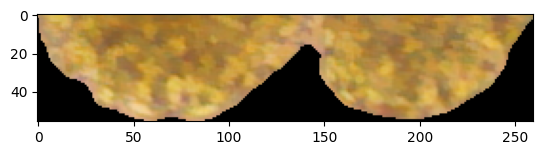

In [13]:
### getting the max and min shape of the spheroids 
imgList = TrainDataset.spheroidInfo[0]
# print(imgList[0].shape)
smallest = 2048
index = 0
for i, item in enumerate (imgList):
    if min(item.shape[:-1]) < smallest and min(item.shape[:-1]) > 3: 
        smallest = min(item.shape[:-1])  
        index = i
        
print(index, smallest, TrainDataset.spheroidInfo[0][index].shape)
plt.imshow(TrainDataset.spheroidInfo[0][index])

In [14]:
# dynamic cnn 
# https://discuss.pytorch.org/t/dynamic-structure-of-cnn/45870

def channels(startFilters, _num_blocks, _num_Channel):
    _enCh = [_num_Channel]
    for num in range(_num_blocks):
        _enCh.append(startFilters * (2**(num)))
    print(_enCh)
    return tuple(_enCh)

class Block(Module):
    def __init__(self, inChannels, outChannels):
        super().__init__()
        self.conv1 = nn.Conv2d(inChannels, outChannels, kernel_size=3, stride=1, padding=1, bias=True)
        self.BN1 = nn.BatchNorm2d(outChannels)
        self.relu1 = nn.ReLU(inplace = True)
        self.dropout = nn.Dropout(0.25)
            
        self.conv2 = Conv2d(outChannels, outChannels, kernel_size=3, stride=1, padding=1, bias=True)
        self.BN2 = BatchNorm2d(outChannels)
        self.relu2 = ReLU(inplace = True)
        
    def forward(self, x):
        # apply CONV => [BN] => RELU => CONV block to the inputs and return it
        outputConv1 = self.dropout(self.relu1(self.BN1(self.conv1(x))))
        outputConv2 = self.relu2(self.BN2(self.conv2(outputConv1))) 
        return outputConv2
    

class Encoder(Module):    
    def __init__(self, channels = None): 
        super().__init__()
        self.channels = channels
        self.encBlocks = ModuleList([Block(channels[i], channels[i + 1]) for i in range(len(channels) -1 )])
        # encoder_blocks = []
        # for i in range(len(self.channels)-1):
        #     # print(channels[i], '-to-', channels[i+1])
        #     encoder_blocks.append(Block(channels[i], channels[i+1]))
        # self.encBlocks = ModuleList(encoder_blocks)
        self.pool = MaxPool2d(kernel_size = 2, stride = 2)

    def forward(self, x): 
        blockOutputs = [] # an empty list (blockOutputs) to store for ML/DL Fc
        for block in self.encBlocks:
            # print(x.size())
            x = block(x)
            blockOutputs.append(x)
            x = self.pool(x)
            # print('Block-')

        return x , blockOutputs

# Starting_filters = 16
# num_blocks = 5
# num_RGBChannel = 3
# enCh = channels(Starting_filters, num_blocks, num_RGBChannel)
# print(summary(Encoder(enCh),input_size=(1, 3, 128, 128), depth = 4, device="cpu"))
# # Encoder(enCh)


- https://stackoverflow.com/questions/72095113/i-want-to-get-the-specific-prediction-of-my-deep-learning-cnn-model-to-a-probab Also, if you want, as you stated, your probabilities of each class to be in this form, 90% class1 and 80% class2 ...etc, you should use sigmoid instead of softmax as your activation function in the output layer. softmax enforces that for each sample, the sum of all classes probabilities is 1 (it is used when classes are exclusive - example: 60 % probability rainy, 40 % probability not rainy), which is not what you want.


In [15]:

class Net(nn.Module):
    def __init__(self, mode = None, spp_level = None, num_classes = None, 
                 NUM_Channel = None, encChannels = None):
        super(Net, self).__init__()
        self.spp_level = spp_level
        self.mode = mode
        self.fcInput = sum(x * x for x in self.spp_level)

        self.encoder = Encoder(encChannels)

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.adpAvgpool = nn.AdaptiveAvgPool2d((32,32))
        self.drop = nn.Dropout(0.25)

        self.classifier = None # add the fc into this one 
        self.relu = ReLU(inplace = True)
        self.dropout = nn.Dropout(0.25)

        self.fc1 = nn.Linear(in_features = encChannels[-1] * self.fcInput, out_features=128) 
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # print('initial tensor', x.size())
        x, convOutputs = self.encoder(x)
        # x = self.encoder(x)
        # print('1st', x.size())
        x = F.relu(spatial_pyramid_pool(x, self.spp_level, self.mode))
        # print('2nd', x.size())
        x = F.dropout(self.drop(x)) #, training=self.training)
        # print('3rd', x.size())
        x = x.view(-1, x.size(1))
        # print('4th', x.size())
        x = self.fc1(x)
        # print('5th', x.size())
        x = self.dropout(self.relu(x))
        # print('6th', x.size())
        x = self.fc2(x)
    
        # x = torch.log_softmax(x, dim=1) #, convOutputs
        x = torch.softmax(x, dim=1)
        return x
    
# Starting_filters = 16
# num_blocks = 5
# mode = 'max'
# num_classes = 2
# num_RGBchannel = 3
# spp_level = [2, 1]
# # enCh = channels(Starting_filters, num_blocks, num_channel) 
# print('total Filters for the Convolution blocks -', enCh)
# model = Net(mode, spp_level, num_classes,  num_RGBchannel, enCh)
# # torch.Size([1, 3, 324, 302])
# # torch.Size([1, 3, 93, 107])
# summary(model, input_size = (1, 3, 93, 107), depth = 4,  device = "cpu", verbose=0)


## training and testing 
- cnn from scartch https://medium.com/swlh/deep-learning-for-image-classification-creating-cnn-from-scratch-using-pytorch-d9eeb7039c12
- loss with weights https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = (self.alpha[targets] * (1 - pt) ** self.gamma * ce_loss).mean()
        return loss
    
# print(class_weights)
# print(class_weights * len(TrainDataset))

In [22]:
# https://medium.com/swlh/deep-learning-for-image-classification-creating-cnn-from-scratch-using-pytorch-d9eeb7039c12

def Train(epoch, train_loader, model, print_every=0):
    total_loss = 0
    start_time = time.time()
    accuracy = []
    model.train()
    
    for i, batch in enumerate(train_loader):
        x, target = (batch[0]/255).to(device) ,  batch[3].to(device) # mask, label = batch[1], batch[2]
        # print(x.shape)
        pred = model(x) # output by our model

        loss = criterion(pred, target) # compute cross entropy loss
        # print('loss', loss)
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = torch.argmax(pred, dim =1)
        # argmax = pred.argmax(dim=1) # Get the class index with maximum probability predicted by the model
        accuracy.append((target == argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor
        # print('argmax', argmax)
        # print('target', target)
        end_time = time.time()
    return sum(accuracy)/len(train_loader), total_loss/len(train_loader) # Returning Average Training Loss


def Test(epoch, test_dataloader, model):
    total_loss = 0
    start_time = time.time()
    accuracy = [] 
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        model.eval()
        for i, batch in enumerate(test_dataloader):
            x, target = (batch[0]/255).to(device) ,  batch[3].to(device)
            pred = model(x)  # output by our model

            loss = criterion(pred, target) # compute cross entropy loss
            total_loss += loss.item()
            argmax = torch.argmax(pred, dim =1)
            # argmax = pred.argmax(dim=1) # Find the index(0, 1 or 2) with maximum score (which denotes class with maximum probability)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets

    return sum(accuracy)/len(test_dataloader), total_loss/len(test_dataloader) # Returning Average Testing Loss

## show results 
- https://github.com/Aggarwal-Abhishek/BasicCNN_Pytorch/blob/main/BasicCNN_Pytorch.ipynb

# combining all the property together

In [23]:
def dataSet_dataLoaderCreation(_prop, _transform, _path,_combinedCsvPath):
    dataset = ebDataset(_path, _combinedCsvPath, filterCols, featureCols, prop = _prop, transform = _transform, num_augmentations = 2)
    train_set, validation_set = torch.utils.data.random_split(dataset, [round(len(dataset) * (1-validation_split)),
                                                                         round(len(dataset) * validation_split)])  
    # create trainLoader
    train_data = [dataset.spheroidInfo[2][i] for i in train_set.indices]
    data = pd.Series(train_data)
    class_counts = data.value_counts()
    class_weights = 1. / (torch.tensor(class_counts.values, dtype=torch.float32) / len(train_set))
    sample_weights = [1/class_counts[i] for i in data.values]; 
    wSampler= WeightedRandomSampler(weights = sample_weights, num_samples = len(train_set), replacement=True)
    trainLoader = DataLoader(dataset = train_set, batch_size = b, sampler = wSampler, collate_fn = custom_collate, num_workers = 0)

    # create ValidationLoader
    val_data = [TrainDataset.spheroidInfo[2][i] for i in validation_set.indices]
    data = pd.Series(val_data)
    class_counts = data.value_counts()
    sample_weights = [1/class_counts[i] for i in data.values]; 
    wSampler= WeightedRandomSampler(weights = sample_weights, num_samples = len(validation_set), replacement=True)
    validationLoader = DataLoader(dataset = validation_set, batch_size = b, sampler = wSampler, collate_fn = custom_collate, num_workers = 0)
    return trainLoader, validationLoader, class_weights

def Train(epoch, train_loader, model, print_every=0):
    total_loss = 0
    start_time = time.time()
    accuracy = []
    model.train()
    
    for i, batch in enumerate(train_loader):
        x, target = (batch[0]/255).to(device) ,  batch[3].to(device) # mask, label = batch[1], batch[2]
        pred = model(x) # output by our model

        loss = criterion(pred, target) # compute cross entropy loss
        total_loss += loss.item()

        optimizer.zero_grad() # Clear the gradients if exists. (Gradients are used for back-propogation.)
        loss.backward() # Back propogate the losses
        optimizer.step() # Update Model parameters
        
        argmax = torch.argmax(pred, dim =1)
        accuracy.append((target == argmax).sum().item() / target.shape[0]) # calculate accuracy by comparing to target tensor
        end_time = time.time()
    return sum(accuracy)/len(train_loader), total_loss/len(train_loader) # Returning Average Training Loss


def Test(epoch, test_dataloader, model):
    total_loss = 0
    start_time = time.time()
    accuracy = [] 
    
    with torch.no_grad(): # disable calculations of gradients for all pytorch operations inside the block
        model.eval()
        for i, batch in enumerate(test_dataloader):
            x, target = (batch[0]/255).to(device) ,  batch[3].to(device)
            pred = model(x)  # output by our model

            loss = criterion(pred, target) # compute cross entropy loss
            total_loss += loss.item()
            argmax = torch.argmax(pred, dim =1)
            accuracy.append((target==argmax).sum().item() / target.shape[0]) # Find the accuracy of the batch by comparing it with actual targets
    return sum(accuracy)/len(test_dataloader), total_loss/len(test_dataloader) # Returning Average Testing Loss


def save_checkpoint(_model = None, _modelName = None, _file_path = None):
    print(" =====> Saving the complete model")
    if _file_path == None: 
        _file_path = pwd() + f"/{_modelName}_FullModel.pth"
    else: 
        _file_path = _file_path + f"/{_modelName}_FullModel.pth"
    torch.save(_model, _file_path)
    return _file_path


In [24]:

def plotResults(_train_loss, _test_loss, _test_acc, _modelName, _prop, _dir):
    plt.figure(figsize=(10, 6))
    plt.style.use("ggplot")

    plt.plot(_train_loss, label="train_loss", marker='d')
    plt.plot(_test_loss, label="test_loss", marker='p')
    plt.plot(_test_acc, label="test_accuracy", marker='o')

    plt.title(f"{_prop} Model Results \n{_modelName}\ntestAccuracy-{_test_acc[-1]:.2f}") 
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
#     plt.xticks(np.arange(0, len(train_loss), 1.0))
#     plt.yticks(np.arange(0, 1, 0.1))

    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.tight_layout()
    
    save_path = os.path.join(_dir, f'{_prop}_{_modelName}_lossGraph.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    return

def plotRandoExamples(model, _modelName, dataset, _prop, _props):
    figure, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (10,5), sharex = False, sharey = False)
    for i, ax in enumerate(axs.flatten()):
        index = random.randrange(len(dataset))
        image = np.float32(dataset[index][0]/255.0) 
        image_tensor = (torch.from_numpy(image).permute(2,0,1).unsqueeze(0)).to(device)
        pred = model(image_tensor)
        argmax = torch.argmax(pred, dim =1)
        
        predName = _props[0] if argmax.item() == 1 else _props[1]
        ax.imshow(image)
        ax.grid(False)
        ax.title.set_text(f"target: {dataset[index][2]}({dataset[index][3]})\n pred: {predName}({argmax[0]})")
        ax.title.set_fontsize(6) 
        ax.tick_params(axis='both', which='major', labelsize=5)
#         break

    figure.suptitle(f"{prop} Prediction for {(len(axs.flatten()))} random Embryonic bodies where 0-{_props[1]}, 1-{_props[0]}", fontsize = 10)
    plt.tight_layout()
    plt.savefig(f'{_prop}-RandomEmbryonicBodies{_modelName}.png')
    plt.show()
    

def modelTesting(_prop, _path, _combinedCsvPath, _modelFilePath, _modelName):
    dataset = ebDataset(_path, combinedCsvPath, filterCols, featureCols, prop = _prop, transform = False, num_augmentations = 0)
    model = torch.load(_modelFilePath)
    model.eval()
    props = []
    
    if _prop == 'cysticity': props = ['Cystic', 'NonCystic']
    elif _prop == 'outline': props = ['RoughOutline', 'SmoothOultine']
    elif _prop == 'shape': props = ['Roundshaped', 'IrregularShaped']
        
    plotRandoExamples(model, _modelName, dataset, _prop, props)
     
    target_prop, target_label = [], []
    pred_label, pred_prop, correct_pred = [], [], []


    for i, item in enumerate(dataset):
        img = np.float32(item[0]/255.0) 
        img_tensor = (torch.from_numpy(img).permute(2,0,1).unsqueeze(0)).to(device)
        label = item[3]
        pred = model(img_tensor)
        argmax = torch.argmax(pred, dim = 1)
        correct_pred.append((item[3] == argmax).sum().item())
        pred_label.append(argmax.item())
        target_prop.append(item[2]); target_label.append(item[3])
    
    acc = sklearn.metrics.accuracy_score(target_label, pred_label)
    Precision = sklearn.metrics.precision_score(target_label, pred_label)
    cm = sklearn.metrics.confusion_matrix(target_label, pred_label)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm)
    
    plt.figure(figsize=(10, 8))
    ax = plt.subplot()
    sns.heatmap(cm, annot = True, fmt = 'g', cbar = False, ax = ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title(f'{_prop} - Confusion Matrix\n{_modelName}\naccuracy-{acc}\nprecison-{Precision}')
    ax.xaxis.set_ticklabels([props[1], props[0]])
    ax.yaxis.set_ticklabels([props[1], props[0]])
    plt.savefig(f'{_prop}-ConfusionMatrix_{_modelName}.png')
    plt.show()
    plt.close()
    
    return  acc 


[3, 8, 16, 32, 64, 128]
--> Analysis for outline
Clearing the cache memory
| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |
|  1 |  0% |  0% |
None
lr0.001_ep100_bSz30_vls0.3_AugTrue:2
 =====> Saving the complete model

epoch: 5/100
 -->train_Loss: 0.32125
 -->test_Loss: 0.34394
 -->test_acc: 0.69474

 =====> Saving the complete model

epoch: 10/100
 -->train_Loss: 0.32499
 -->test_Loss: 0.52165
 -->test_acc: 0.72281

 =====> Saving the complete model

epoch: 15/100
 -->train_Loss: 0.31771
 -->test_Loss: 0.42189
 -->test_acc: 0.72632

 =====> Saving the complete model

epoch: 20/100
 -->train_Loss: 0.31685
 -->test_Loss: 0.42253
 -->test_acc: 0.70877

 =====> Saving the complete model

epoch: 25/100
 -->train_Loss: 0.31890
 -->test_Loss: 0.38801
 -->test_acc: 0.70877

 =====> Saving the complete model

epoch: 30/100
 -->train_Loss: 0.32081
 -->test_Loss: 0.34336
 -->test_acc: 0.72807

 =====> Saving the complete model

epoch: 35/100
 -->train_Loss: 0.31417
 -->test_Loss: 0.3969

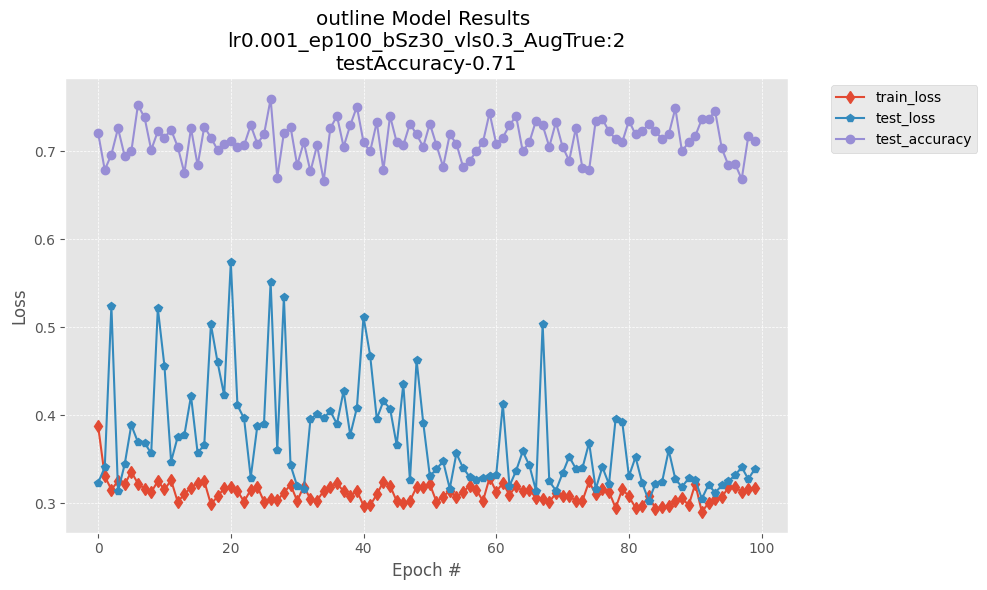

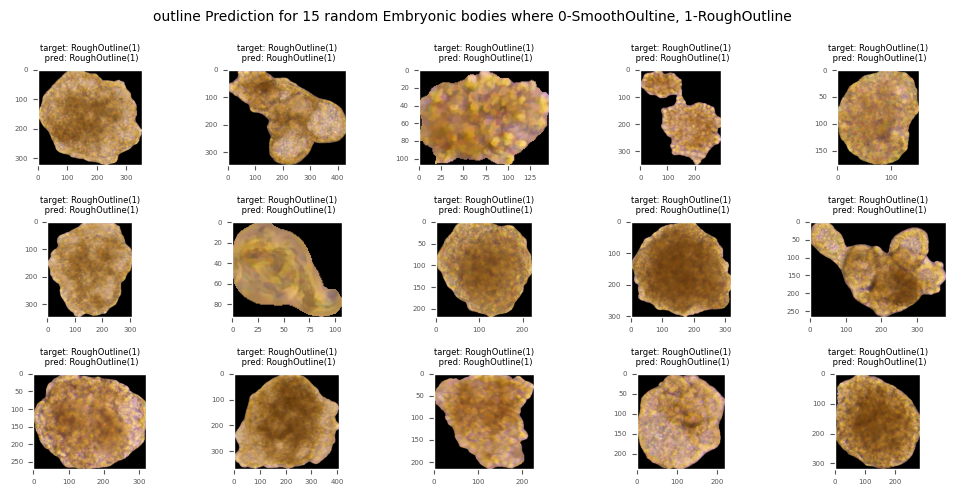

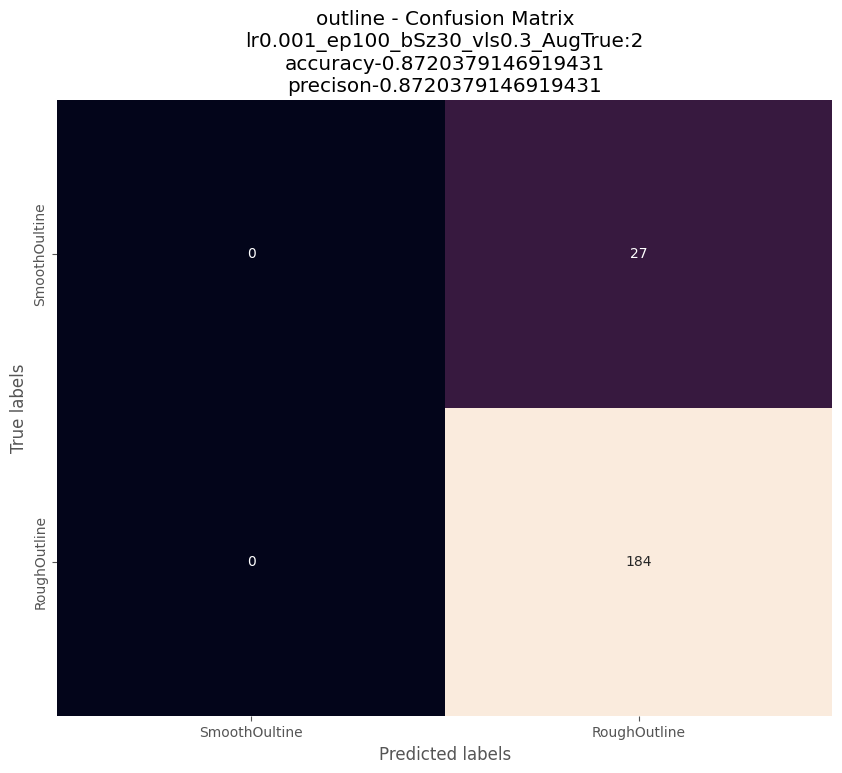

Accuracy for outline - 0.8720379146919431
| ID | GPU | MEM |
------------------
|  0 |  3% | 76% |
|  1 |  0% | 98% |
None

--> Analysis for cysticity
Clearing the cache memory
| ID | GPU | MEM |
------------------
|  0 |  3% | 76% |
|  1 |  0% | 98% |
None
lr0.001_ep100_bSz30_vls0.3_AugTrue:2
 =====> Saving the complete model

epoch: 5/100
 -->train_Loss: 0.22102
 -->test_Loss: 0.17690
 -->test_acc: 0.87368

 =====> Saving the complete model

epoch: 10/100
 -->train_Loss: 0.20986
 -->test_Loss: 0.19368
 -->test_acc: 0.79825

 =====> Saving the complete model

epoch: 15/100
 -->train_Loss: 0.19103
 -->test_Loss: 0.17335
 -->test_acc: 0.84912

 =====> Saving the complete model

epoch: 20/100
 -->train_Loss: 0.17380
 -->test_Loss: 0.22500
 -->test_acc: 0.71228

 =====> Saving the complete model

epoch: 25/100
 -->train_Loss: 0.16096
 -->test_Loss: 0.18653
 -->test_acc: 0.79649

 =====> Saving the complete model

epoch: 30/100
 -->train_Loss: 0.16893
 -->test_Loss: 0.17142
 -->test_acc: 0

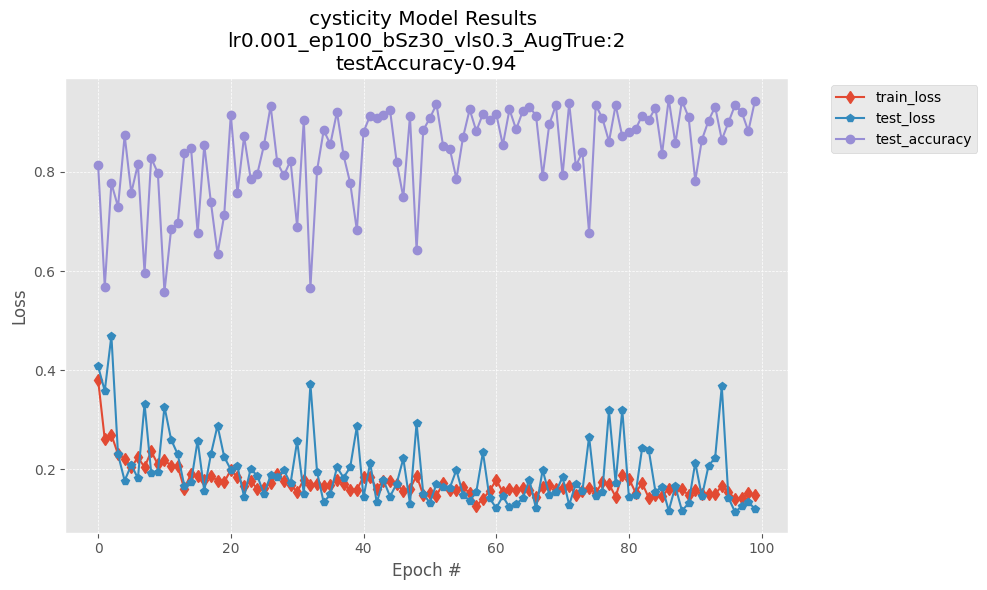

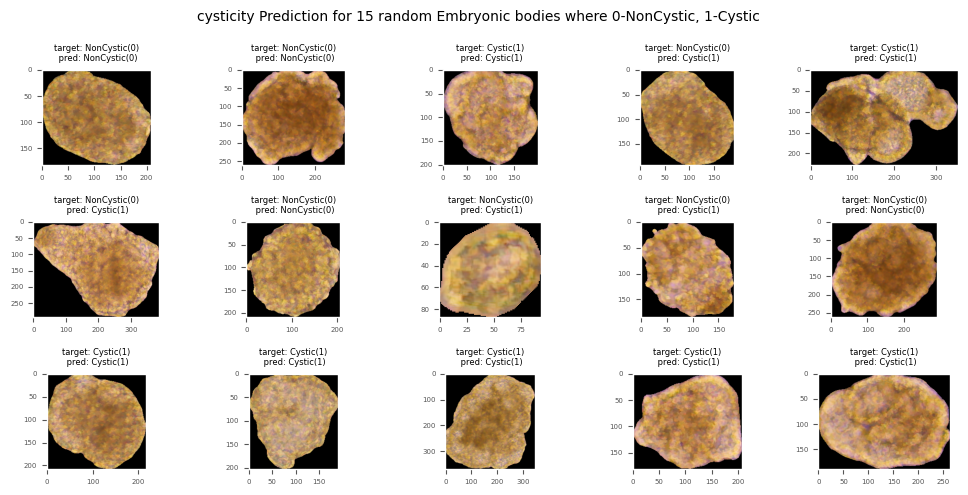

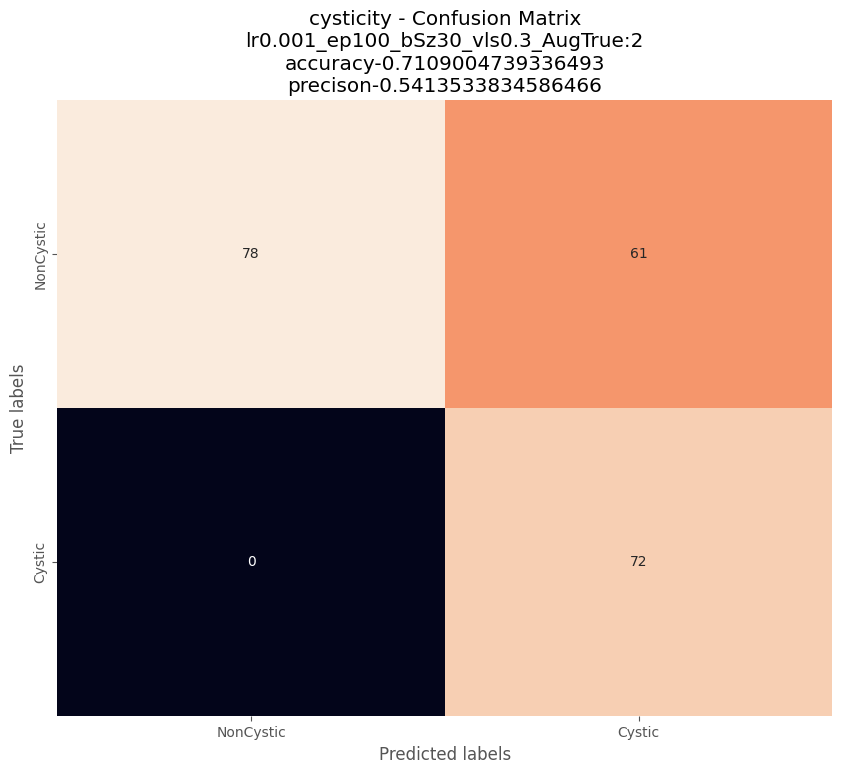

Accuracy for cysticity - 0.7109004739336493
| ID | GPU | MEM |
------------------
|  0 |  0% | 94% |
|  1 |  0% | 91% |
None

--> Analysis for shape
Clearing the cache memory
| ID | GPU | MEM |
------------------
|  0 |  0% | 94% |
|  1 |  0% | 91% |
None
lr0.001_ep100_bSz30_vls0.3_AugTrue:2
 =====> Saving the complete model

epoch: 5/100
 -->train_Loss: 0.35101
 -->test_Loss: 0.33375
 -->test_acc: 0.71228

 =====> Saving the complete model

epoch: 10/100
 -->train_Loss: 0.35246
 -->test_Loss: 0.29380
 -->test_acc: 0.76316

 =====> Saving the complete model

epoch: 15/100
 -->train_Loss: 0.34853
 -->test_Loss: 0.28685
 -->test_acc: 0.76667

 =====> Saving the complete model

epoch: 20/100
 -->train_Loss: 0.35833
 -->test_Loss: 0.30396
 -->test_acc: 0.74737

 =====> Saving the complete model

epoch: 25/100
 -->train_Loss: 0.32745
 -->test_Loss: 0.26960
 -->test_acc: 0.78947

 =====> Saving the complete model

epoch: 30/100
 -->train_Loss: 0.34924
 -->test_Loss: 0.29664
 -->test_acc: 0.7

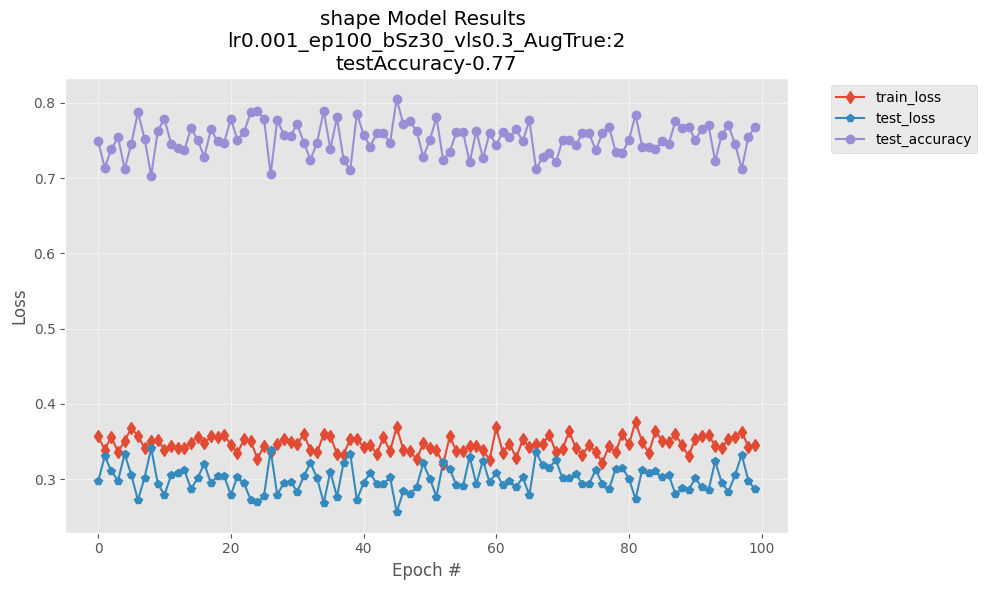

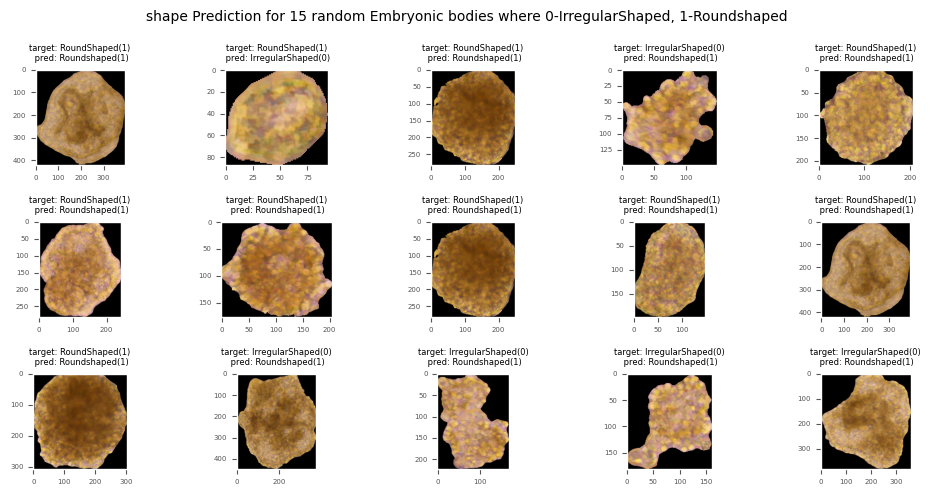

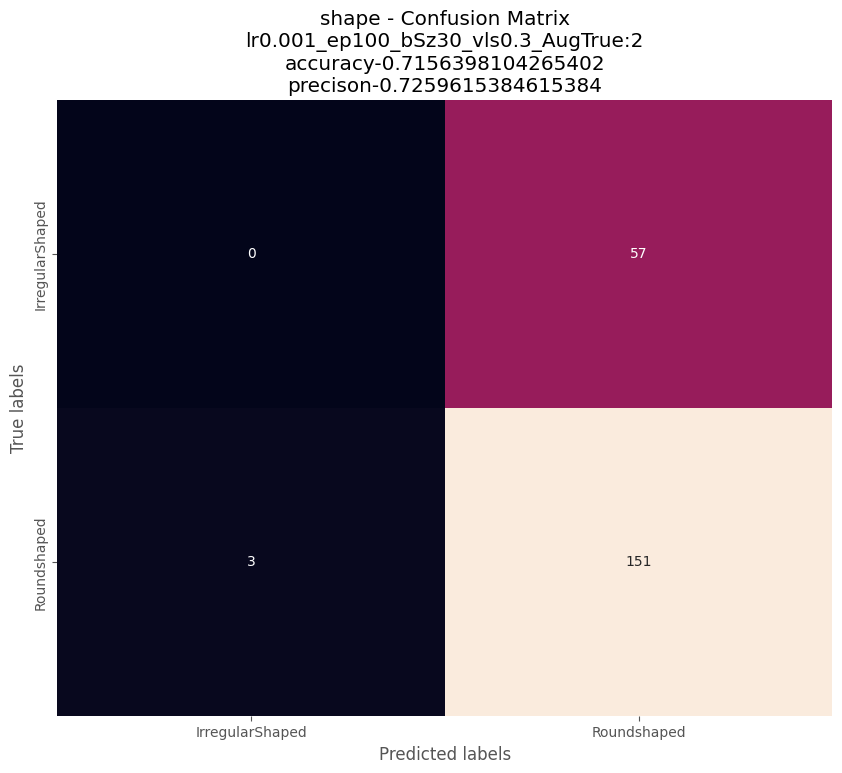

Accuracy for shape - 0.7156398104265402
| ID | GPU | MEM |
------------------
|  0 |  0% | 76% |
|  1 |  0% | 95% |
None

Results saved to training_results.pickle


In [25]:
propList = ['outline','cysticity', 'shape']
trainSet_imgPath = '/kaggle/input/profiling-of-spheroids/spheroidDetails' 
testSet_imgPath = '/kaggle/input/profiling-of-spheroids/testSpheroidDetails'
combinedCsvPath = '/kaggle/input/profiling-of-spheroids/combined_csvPath/combinedAnnotated.csv'
b = 30

lr = 1e-3
Starting_filters = 8
num_blocks = 5
mode = 'max'
num_classes = 2
num_RGBchannel = 3
spp_level = [2, 1]
enCh = channels(Starting_filters, num_blocks, num_RGBchannel)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = True
NUM_AUGMENTATION = 2
validation_split = 0.3
Num_epochs = 100

result_dict = {}

for prop in propList:
    print(f'--> Analysis for {prop}')
    print('Clearing the cache memory')
    print(gpu_usage())
    with torch.no_grad():
        torch.cuda.empty_cache()
        
    trainLoader, validationLoader, class_weights = dataSet_dataLoaderCreation(prop, transform, trainSet_imgPath, combinedCsvPath)
    
    model = Net(mode, spp_level, num_classes,  num_RGBchannel, enCh)
    model = nn.DataParallel(model).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5)
    criterion = FocalLoss(alpha = class_weights.to(device))
    if transform == True: modelName = f"lr{lr}_ep{Num_epochs}_bSz{b}_vls{validation_split}_Aug{transform}:{NUM_AUGMENTATION}"
    else: modelName = f"{prop}_lr{lr}_ep{Num_epochs}_bSz{b}_vls{validation_split}_Aug{_transform}"
    print(modelName)
    
#     print('perform training')
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []
    
    for epoch in range(Num_epochs):
        
        acc, loss = Train(epoch, trainLoader, model)
        train_loss.append(loss)
        train_acc.append(acc)
        
        acc, loss = Test(epoch, validationLoader, model)
        test_loss.append(loss)
        test_acc.append(acc)
        
        if (epoch+1)%5 == 0:
            modelFilePath = save_checkpoint(_model = model, _modelName = modelName, _file_path = BASE_OUTPUT) 
            print(f'\nepoch: {epoch+1}/{Num_epochs}\n -->train_Loss: {train_loss[epoch]:.5f}\n -->test_Loss: {test_loss[epoch]:.5f}\n -->test_acc: {test_acc[epoch]:.5f}\n')
           
    plotResults(train_loss, test_loss, test_acc, _modelName = modelName, _prop = prop, _dir = BASE_OUTPUT)
    result_dict[f'{prop}'] = {'train_loss': train_loss, 'train_acc': train_acc,
                              'test_loss': test_loss, 'test_acc': test_acc }
    acc = modelTesting(prop, testSet_imgPath, combinedCsvPath, modelFilePath, modelName)
    print(f'Accuracy for {prop} - {acc}')
    
    print(f'{gpu_usage()}\n')
#     break
    
with open('training_results.pickle', 'wb') as handle:
    pickle.dump(result_dict, handle)

print("Results saved to training_results.pickle")

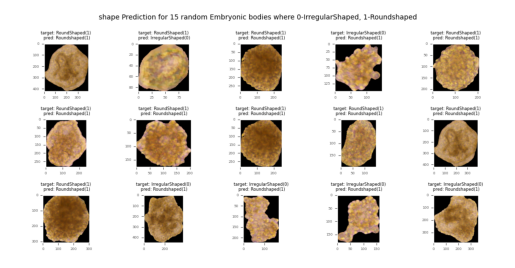

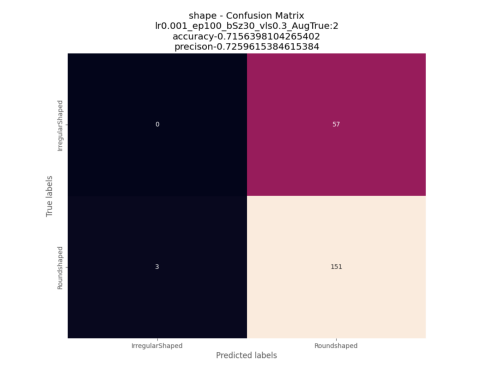

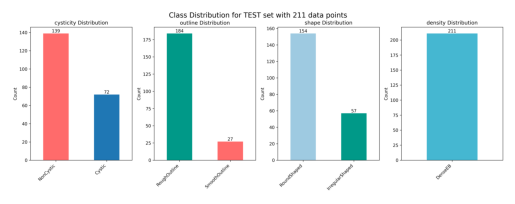

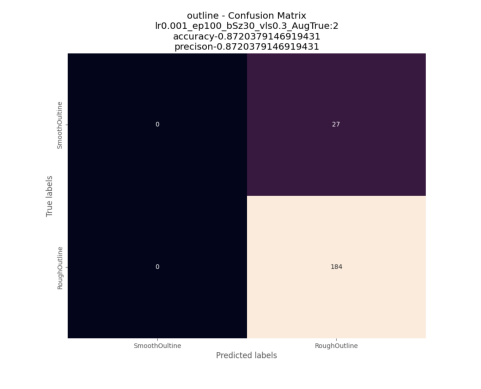

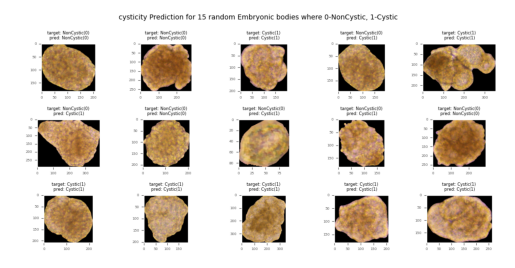

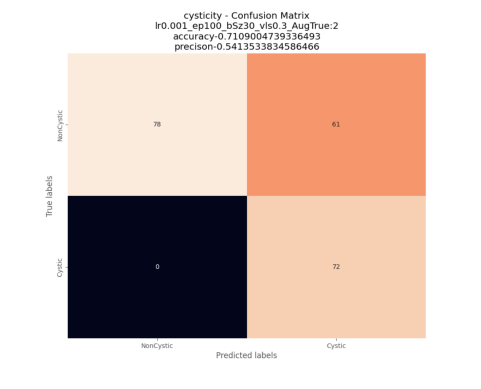

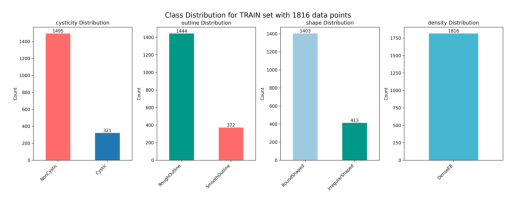

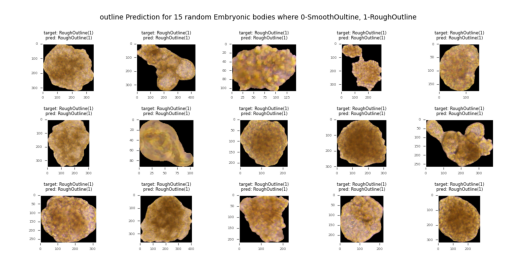

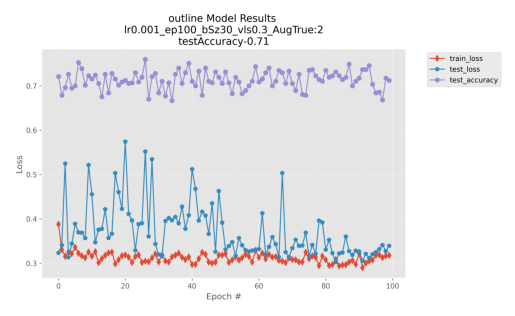

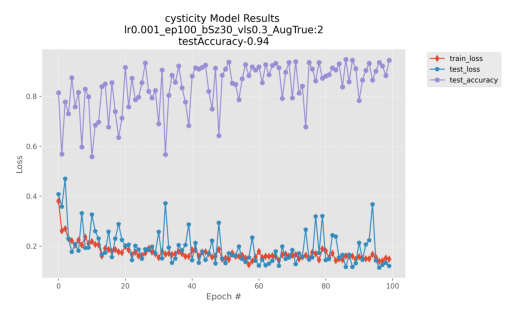

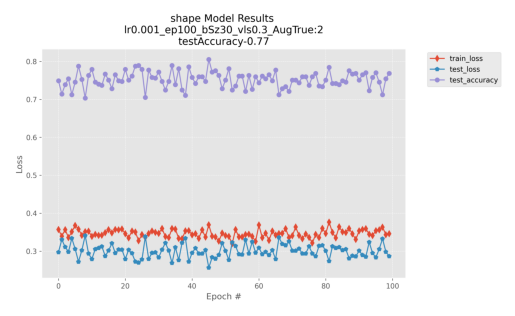

In [27]:
for item in os.listdir(BASE_OUTPUT):
    _, extension = os.path.splitext(item)
    if extension == '.png':
        img_path = os.path.join(BASE_OUTPUT, item)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()